### TRAIN.PY

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
from scipy import stats

In [ ]:
from pathlib import Path

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 11.4 MB/s eta 0:00:00


In [ ]:
from tqdm.auto import tqdm
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter

In [ ]:
import torchmetrics
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from torchmetrics import Precision, Recall, F1Score
from torchmetrics import AUROC
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from itertools import cycle

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights
import torch
from torch import nn
from torch.nn import Module
from typing import Tuple, Dict, List
import torchvision.io as tio
from torchvision import transforms

## Save model

In [ ]:
def save_model(model:torch.nn.Module,
               target_dir:str,
               model_name:str)->None:
    td = Path(target_dir)
    if not td.is_dir():
        td.mkdir(parents=True, exist_ok=True)
    md = td / model_name
    torch.save(obj = model.state_dict(),
               f = md)
    print(f'saved to {md}')

## Gather files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path= '/content/drive/MyDrive/Diploma_folder/Diploma/cl_nastya_ref'

In [ ]:
NUM_WORKERS = 1

In [ ]:
LABELS = []
PATHS = []
classes = []

In [ ]:
for root, dirs, files in os.walk(data_path):
    if len(files)!=0:
        PATHS+=files
        LABELS+=[root.split('/')[-1]]*len(files)
    else:
        classes+=dirs

In [ ]:
print(classes)

['push up', 'leg raises', 'twist']


## Dataset

In [ ]:
class BWDataset(Dataset):
    def __init__(self, target_dir_path:str, paths:List[str], labels:List[str], classes:List[str], transform = None, train:bool=True)->None:
        super().__init__()
        self.dir = target_dir_path
        self.paths = paths
        self.labels = labels
        self.is_train = train
        if transform:
            self.zero_transform = transforms.TrivialAugmentWide()
            self.transform = transform
        else:
            self.transform = None
        self.classes, self.class_to_idx = classes, {cl:i for i,cl in enumerate(classes)}

    def load_image(self, index:int)->torch.Tensor:
        image = tio.read_image(os.path.join(self.dir, self.labels[index], self.paths[index]))
        if self.is_train and self.transform:
            image = self.zero_transform(image)
        image = image.type(torch.float32)/255.
        return image

    def __len__(self)->torch.Tensor:
        return len(self.paths)

    def __getitem__(self, index)->Tuple[torch.tensor, int]:
        image = self.transform(self.load_image(index)) if self.transform else self.load_image(index)
        cl_ind = self.class_to_idx[self.labels[index]]
        return image, cl_ind

In [ ]:
dset = BWDataset(target_dir_path = data_path, paths = PATHS, labels = LABELS, classes = classes)

In [ ]:
dset.class_to_idx

{'push up': 0, 'leg raises': 1, 'twist': 2}

In [ ]:
def create_dataloaders(target_dir_path = data_path,
                       paths = PATHS,
                       labels = LABELS,
                       classes = classes,
                       transform:transforms.Compose = transforms.Compose([transforms.Resize((360,360))]),
                       batch_size:int = 32,
                       num_workers:int = NUM_WORKERS):
    train_paths, test_paths, train_labels, test_labels =  train_test_split(paths, labels, test_size=0.33, random_state=42)#, stratify=labels)
    train_dataset_simple = BWDataset(target_dir_path = target_dir_path, paths = train_paths, labels = train_labels, classes = classes, transform = transform, train=True)
    test_dataset_simple = BWDataset(target_dir_path = target_dir_path, paths = test_paths, labels = test_labels, classes = classes, transform = transform, train=False)
    class_names = train_dataset_simple.classes
    train_dataloader = DataLoader(train_dataset_simple, batch_size=batch_size,
                                  shuffle=True,
                                  pin_memory=True,)
    test_dataloader = DataLoader(test_dataset_simple, batch_size=batch_size,
                                 shuffle = False,
                                 pin_memory=True,)
    return train_dataloader, test_dataloader, class_names

## Download data formatting operations for ResNet50

In [ ]:
weights = ResNet50_Weights.IMAGENET1K_V1
preprocess = weights.transforms()

In [ ]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
train_dataloader, test_dataloader, class_names = create_dataloaders(transform = preprocess)

## Model

In [ ]:
class ResNet50(Module):
    def __init__(self, output_classes:int, weights=weights, init_weights=True)->None:
        super().__init__()
        weights = ResNet50_Weights.IMAGENET1K_V1
        self.rn50 = resnet50(weights=weights)
        #self.rn50.requires_grad = False
        self.cl = nn.Sequential(
            nn.Flatten(),
            nn.ReLU(),
            nn.Linear(in_features = 1000, out_features = 32),
            nn.ReLU(),
            nn.Linear(in_features = 32, out_features = 32),
            nn.ReLU(),
            nn.Linear(in_features = 32, out_features = output_classes)
        )
        self.name = 'ResNet50'

    def forward(self, x:torch.Tensor):
        return self.cl(self.rn50(x))

In [ ]:
custom_res_net = ResNet50(len(classes))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 83.9MB/s]


## Default functions

In [ ]:
def create_writer(experiment_name: str,
                   model_name: str,
                   extra = None)->torch.utils.tensorboard.writer.SummaryWriter():
    from datetime import datetime
    import os

    timestamp = datetime.now().strftime("%Y-%m-%d")
    path = os.path.join("runs", timestamp, experiment_name, model_name)
    if extra:
        path = os.path.join(path, extra)
    print('Path: ',path)
    return SummaryWriter(log_dir=path)

def train_step(model: torch.nn.Module, device:torch.device, dataloader: torch.utils.data.DataLoader,
         accuracy_f: Accuracy, loss_f:torch.nn.Module, optimizer:torch.optim.Optimizer)->Tuple[float, float]:
    loss, accuracy = 0, 0
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        preds = model(X)
        bloss = loss_f(preds, y)
        bacc = accuracy_f(torch.softmax(preds, dim=1).argmax(dim=1), y)
        optimizer.zero_grad()
        bloss.backward()
        optimizer.step()
        loss, accuracy = loss+bloss, accuracy+bacc.detach().cpu().item()
    loss, accuracy = loss/len(dataloader), accuracy/len(dataloader)
    #print(accuracy, loss)
    return loss, accuracy

def test_step(model: torch.nn.Module, device:torch.device, dataloader: torch.utils.data.DataLoader,
         accuracy_f: Accuracy, loss_f:torch.nn.Module)->Tuple[float, float]:
    loss, accuracy = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            preds = model(X)
            bloss = loss_f(preds, y)
            bacc = accuracy_f(torch.softmax(preds, dim=1).argmax(dim=1), y)
            loss, accuracy = loss+bloss, accuracy+bacc.detach().cpu().item()
    loss, accuracy = loss/len(dataloader), accuracy/len(dataloader)
    return loss, accuracy

def train(model: torch.nn.Module, device:torch.device, train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,accuracy_f: Accuracy, loss_f:torch.nn.Module, optimizer:torch.optim.Optimizer,
         epochs:int, writer:torch.utils.tensorboard.writer.SummaryWriter
)->Dict[str, List]:
    results = {'train_loss' : [],
              'train_acc' : [],
              'test_loss' : [],
              'test_acc' : []}
    model.to(device)
    for epoch in tqdm(range(epochs)):
        res = train_step(model, device, train_dataloader, accuracy_f, loss_f, optimizer)
        tres = test_step(model, device, test_dataloader, accuracy_f, loss_f)
        results['train_loss'].append(res[0])
        results['train_acc'].append(res[1])
        results['test_loss'].append(tres[0])
        results['test_acc'].append(tres[1])
        print(f'Train loss {res[0]} | Train acc {res[1]} | Test loss {tres[0]} | Test acc {tres[1]}')
        writer.add_scalars(main_tag='Accuracy', tag_scalar_dict={'train_accuracy':res[1],
                                                        'test_accuracy':tres[1]},
                           global_step=epoch)
        writer.add_scalars(main_tag='Loss', tag_scalar_dict={'train_loss' : res[0].detach().cpu().item(),
                                                             'test_loss' : tres[0].detach().cpu().item()},
                           global_step=epoch)
        writer.close()
    return results


In [ ]:
def plot_k_random(model, samples, transform, classes, device):
    classes = classes#sorted(classes)

    model.eval()
    model.to(device)
    print(samples[0].shape, len(samples))
    with torch.inference_mode():
        for i, X in enumerate(samples):
            print('a')
            p = torch.softmax(model(X.to(device).unsqueeze(dim=0)), dim=1)
            print('a')
            pred = torch.argmax(p, dim=1)
            print('a')
            plt.subplot(1, len(samples)+1, i+1)
            plt.imshow(X.cpu().permute(1, 2, 0))
            print([j for j in p.detach().cpu()], pred)
            plt.title(f'{classes[pred]},\n prob: {[j.detach().cpu() for j in p][0][pred]}')
        plt.tight_layout()
        plt.show()
        input()

In [ ]:
lr = 0.00005
batch_size = 80
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = [5]#, 10, 20]

In [ ]:
model = custom_res_net

In [ ]:
model.name

'ResNet50'

In [ ]:
for ep in num_epochs:
    train_dataloader, test_dataloader, class_names = create_dataloaders(transform = preprocess)
    en = 'Nastya_dataset'
    writer = create_writer(en, model_name = model.name, extra=f'{ep}_epochs')
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    accuracy_fn = torchmetrics.Accuracy(task='multiclass', num_classes=len(classes)).to(device)
    res = train(model, train_dataloader=train_dataloader, test_dataloader=test_dataloader,
               loss_f=loss_fn, accuracy_f=accuracy_fn, optimizer=optimizer,
               device=device, epochs=ep, writer=writer)
    save_model(model, f'.\\models\\Nastya_dataset\\{ep}_epochs', f'{model.name}.pth')


Path:  runs/2024-04-25/Nastya_dataset/ResNet50/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss 0.700714111328125 | Train acc 0.8705357142857143 | Test loss 0.22002267837524414 | Test acc 0.9924568954636069
Train loss 0.15485480427742004 | Train acc 0.9857142857142858 | Test loss 0.041621219366788864 | Test acc 0.9942951307577246
Train loss 0.07385408133268356 | Train acc 0.9785714285714285 | Test loss 0.03329458087682724 | Test acc 0.9924568954636069
Train loss 0.07313431054353714 | Train acc 0.9776785714285714 | Test loss 0.036419905722141266 | Test acc 0.9906186601694893
Train loss 0.03801725432276726 | Train acc 0.9928571428571429 | Test loss 0.025465989485383034 | Test acc 0.9942951307577246
saved to .\models\Nastya_dataset\5_epochs/ResNet50.pth


##Analysis

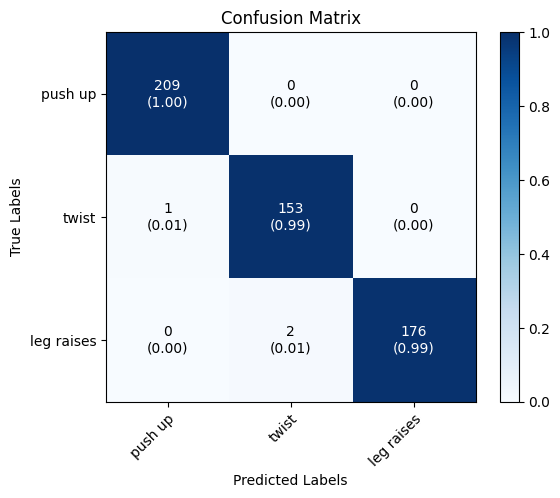

In [ ]:
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Initialize the confusion matrix metric for multiclass classification
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass').to(device)

# Switch model to evaluation mode
model.eval()

# No need to track gradients for validation
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        confmat.update(preds, labels)

# Get the confusion matrix
cm = confmat.compute().cpu().numpy()

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=True,
                                show_normed=True,
                                class_names=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [ ]:

# Ініціалізація метрик з вказанням завдання
precision_metric = Precision(num_classes=len(class_names), average='macro', task='multiclass')
recall_metric = Recall(num_classes=len(class_names), average='macro', task='multiclass')
f1_score_metric = F1Score(num_classes=len(class_names), average='macro', task='multiclass')

# Встановлення пристрою
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Метрики повинні бути на тому ж пристрої, що й вхідні дані та модель
precision_metric.to(device)
recall_metric.to(device)
f1_score_metric.to(device)

# Запуск моделі в режимі оцінки
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        # Оновлення метрик
        precision_metric(preds, labels)
        recall_metric(preds, labels)
        f1_score_metric(preds, labels)

# Розрахунок кінцевих метрик
precision = precision_metric.compute()
recall = recall_metric.compute()
f1_score = f1_score_metric.compute()

print(f'Precision: {precision.item()}')
print(f'Recall: {recall.item()}')
print(f'F1 Score: {f1_score.item()}')


Precision: 0.9941116571426392
Recall: 0.99409019947052
F1 Score: 0.9940849542617798


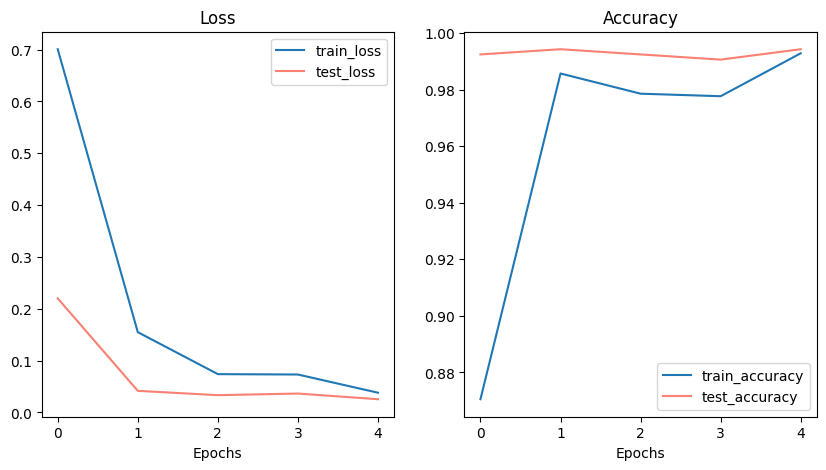

In [ ]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, [l.detach().cpu().item() for l in loss], label="train_loss")
    plt.plot(epochs, [l.detach().cpu().item() for l in test_loss], label="test_loss", color='salmon')
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy", color='salmon')
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

    plt.show()
    #input()

plot_loss_curves(res)

In [ ]:

# Initialize the AUROC metric for multiclass classification
auroc = AUROC(num_classes=len(class_names), average=None, task='multiclass')

# Set up the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
auroc.to(device)

# Switch the model to evaluation mode
model.eval()

# Preparing for AUROC computation
with torch.no_grad():
    all_preds = []
    all_labels = []
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        # Collect softmax probabilities and corresponding labels for AUROC calculation
        probabilities = torch.softmax(outputs, dim=1)
        all_preds.append(probabilities)
        all_labels.append(labels)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Compute AUROC for each class
    class_auroc = auroc(all_preds, all_labels)

# Print AUROC by class
print("AUROC by class:")
for i, score in enumerate(class_auroc):
    print(f"Class {class_names[i]}: {score.item()}")

# Optionally, compute overall AUROC using 'macro' or 'weighted' average
auroc_total = AUROC(num_classes=len(class_names), average='macro', task='multiclass').to(device)
with torch.no_grad():
    auroc_total.update(all_preds, all_labels)
total_auroc_score = auroc_total.compute()
print(f"Total AUROC: {total_auroc_score.item()}")


AUROC by class:
Class push up: 0.9999567270278931
Class twist: 0.9998321533203125
Class leg raises: 0.9999845623970032
Total AUROC: 0.9999245405197144


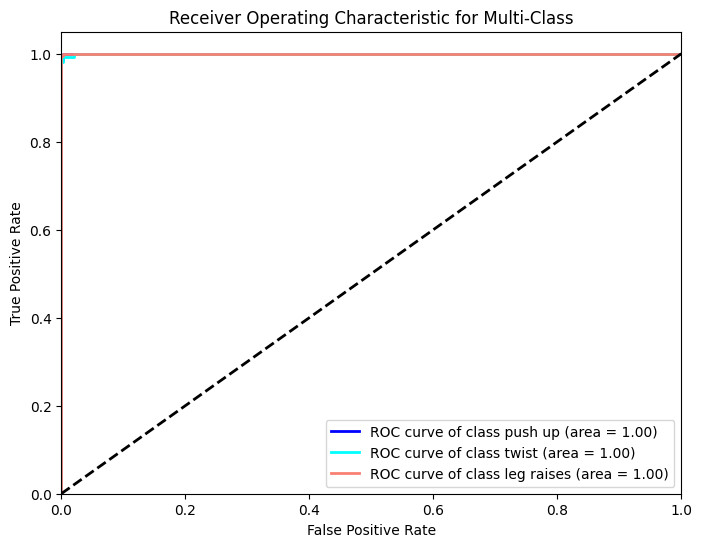

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Assuming 'model' is your trained model and 'test_dataloader' is your PyTorch DataLoader for the test set
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

# Prepare to collect test outputs
softmax = torch.nn.Softmax(dim=1)
all_preds = []
all_targets = []

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        outputs = model(images)
        probabilities = softmax(outputs)
        all_preds.append(probabilities.cpu())
        all_targets.append(labels.cpu())

# Concatenate all results
all_preds = torch.cat(all_preds, dim=0).numpy()
all_targets = torch.cat(all_targets, dim=0).numpy()

# Binarize the labels in a one-hot fashion
all_targets = label_binarize(all_targets, classes=[i for i in range(len(class_names))])
n_classes = all_targets.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_targets[:, i], all_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['blue', 'cyan', 'salmon'])
plt.figure(figsize=(8, 6))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()



## Inferencing

In [ ]:
from PIL import Image as im

In [ ]:
inf_mdl = ResNet50(len(classes))

In [ ]:
inf_mdl = ResNet50(len(classes))
inf_mdl.load_state_dict(torch.load('/content/drive/MyDrive/Diploma_folder/Diploma/ResNet50.pth'))
inf_mdl.eval()
inf_mdl.cuda()

In [ ]:
auto_transforms = weights.transforms()

In [ ]:
resized_to_square = '/content/drive/MyDrive/Diploma_folder/Diploma/Test/leg_raises_test.mp4'
cap = cv2.VideoCapture(resized_to_square)
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(3))
height = int(cap.get(4))
size = (width, height)

In [ ]:
fps

59.94005994005994

In [ ]:
counter = 0
frames = []
while cap.isOpened():
    counter+=1
    ret, frame = cap.read()
    if ret == True:
        frames.append(frame)
    else:
        break

cap.release()

In [ ]:
WINDOWLEN = 20

In [ ]:
cl_to_idx=dset.class_to_idx

In [ ]:
activities = []
with torch.no_grad():
    cur_window = frames[:WINDOWLEN]
    prpr = torch.vstack([auto_transforms(im.fromarray(fr)).unsqueeze(0) for fr in cur_window]).cuda()
    res = inf_mdl(prpr).mean(axis=0)
    probs = torch.softmax(res, dim=-1).argmax(dim=-1)
    cur_activity = torch.mode(probs).values.item()
    activities.append(cur_activity)
    for i, frame in enumerate(frames):
        if i<WINDOWLEN:
            continue
        cur_window = cur_window[1:]+[frame]
        prpr = torch.vstack([auto_transforms(im.fromarray(fr)).unsqueeze(0) for fr in cur_window]).cuda()
        res = inf_mdl(prpr).mean(axis=0)
        probs = torch.softmax(res, dim=-1).argmax(dim=-1)
        cur_activity = torch.mode(probs).values.item()
        activities.append(cur_activity)
        print(i,cur_activity, probs)

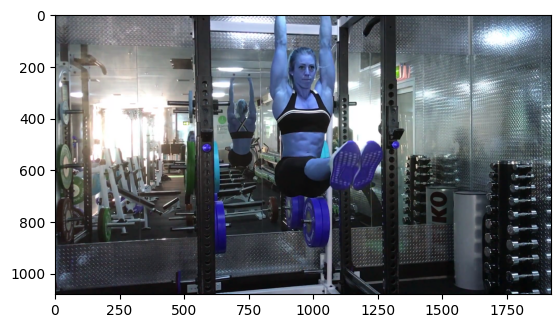

In [ ]:
plt.imshow(frames[700])

In [ ]:
with torch.no_grad():
    prpr = auto_transforms(im.fromarray(frames[520])).unsqueeze(0).cuda()
    es = inf_mdl(prpr)

In [ ]:
es

tensor([[-0.2034,  4.2800, -2.2675]], device='cuda:0')

In [ ]:
i = 690

In [ ]:
WINDOWLEN = 60

In [ ]:
activities = []
with torch.no_grad():
    cur_window = frames[:WINDOWLEN]
    prpr = torch.vstack([auto_transforms(im.fromarray(fr)).unsqueeze(0) for fr in cur_window]).cuda()
    es = inf_mdl(prpr)
    res = es.max(axis=0).values
    probs = torch.softmax(res, dim=-1).argmax(dim=-1)
    cur_activity = torch.mode(probs).values.item()
    activities.append(cur_activity)
    for i, frame in enumerate(frames):
        if i<WINDOWLEN:
            continue
        cur_window = cur_window[1:]+[frame]
        prpr = torch.vstack([auto_transforms(im.fromarray(fr)).unsqueeze(0) for fr in cur_window]).cuda()
        es = inf_mdl(prpr)
        res = es.max(axis=0).values
        probs = torch.softmax(res, dim=-1).argmax(dim=-1)
        cur_activity = torch.mode(probs).values.item()
        activities.append(cur_activity)
        print(i,cur_activity, probs)

In [ ]:
activities

In [ ]:
 d = {0: 'leg raises', 1: 'push up', 2: 'twist'}

In [ ]:
ans = es.mean(axis=0)**2- es.mode(axis=0).values**2

In [ ]:
es.median(axis=0)

torch.return_types.median(
values=tensor([-0.3168,  3.8526, -1.6906], device='cuda:0'),
indices=tensor([20, 27, 38], device='cuda:0'))

In [ ]:
(es.max(axis=0).values-es.min(axis=0).values)

tensor([0.3395, 2.4962, 1.5330], device='cuda:0')

In [ ]:
res

tensor([-0.1946,  4.8899, -0.7946], device='cuda:0')

In [ ]:
with torch.no_grad():
    nres = res.max(axis=0).values

In [ ]:
nres.values

<function Tensor.values>

In [ ]:
_, max_index = torch.max(ans, dim=0)
max_index_value = max_index.item()
exersise = d[max_index_value]

##Repcount and analysis

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.9/757.9 kB 5.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import math
import argparse
from ultralytics import YOLO
import sys
from time import time

In [ ]:
exercises = {
    'leg_raises': {
        'left_keypoints': [6, 12, 14],
        'right_keypoints': [5, 11, 13],
        'maintaining': 70,
        'relaxing': 140,
    },
    'pushup': {
        'left_keypoints': [6, 8, 10],
        'right_keypoints': [5, 7, 9],
        'maintaining': 140,
        'relaxing': 120,
    },
    'twist': {
        'left_keypoints': [15, 6, 10],
        'right_keypoints': [16, 5, 9],
        'maintaining': 50,
        'relaxing': 60,
}
}

In [ ]:
def compute_joint_angle(body_points, left_indices, right_indices):
    def _find_angle_difference(segment1, segment2):

        incline1 = math.atan2(segment1[3] - segment1[1], segment1[2] - segment1[0])
        incline2 = math.atan2(segment2[3] - segment2[1], segment2[2] - segment2[0])


        degrees1 = math.degrees(incline1)
        degrees2 = math.degrees(incline2)


        degree_difference = abs(degrees1 - degrees2)


        if degree_difference > 180:
            degree_difference = 360 - degree_difference

        return degree_difference

    left_coords = [[body_points.data[0][index][0], body_points.data[0][index][1]] for index in left_indices]
    right_coords = [[body_points.data[0][index][0], body_points.data[0][index][1]] for index in right_indices]
    segment1_left = [
        left_coords[1][0].item(), left_coords[1][1].item(),
        left_coords[0][0].item(), left_coords[0][1].item()
    ]
    segment2_left = [
        left_coords[1][0].item(), left_coords[1][1].item(),
        left_coords[2][0].item(), left_coords[2][1].item()
    ]
    left_angle = _find_angle_difference(segment1_left, segment2_left)
    segment1_right = [
        right_coords[1][0].item(), right_coords[1][1].item(),
        right_coords[0][0].item(), right_coords[0][1].item()
    ]
    segment2_right = [
        right_coords[1][0].item(), right_coords[1][1].item(),
        right_coords[2][0].item(), right_coords[2][1].item()
    ]
    right_angle = _find_angle_difference(segment1_right, segment2_right)
    return left_angle, right_angle

In [ ]:
def execute_video_analysis():
    parameters = fetch_settings()
    pose_model = YOLO(parameters.model)
    video_stream = cv2.VideoCapture(parameters.video_source)
    is_reaching, last_reaching_status, motion_detected, repetition_count = False, False, False, 0
    skip_frames, processed_frames = 5, 0

    left = []
    right = []
    cur = []
    times = []
    last_time = None

    while video_stream.isOpened():
        frame_available, frame = video_stream.read()
        if not frame_available:
            break
        if processed_frames % skip_frames == 0:
            pose_results = pose_model(frame)
            left_indices, right_indices = exercises[parameters.exercise_type]['left_keypoints'], exercises[parameters.exercise_type]['right_keypoints']
            left_angle, right_angle = compute_joint_angle(pose_results[0].keypoints, left_indices, right_indices)


            print(left_angle, right_angle)
            left.append(left_angle)
            right.append(right_angle)
            if hasattr(parameters, 'visible_side'):
                if parameters.visible_side == 'left':
                    current_angle = left_angle
                elif parameters.visible_side == 'right':
                    current_angle = right_angle
            else:
                current_angle = (left_angle + right_angle) / 2

            print(current_angle)
            cur.append(current_angle)


            if current_angle < exercises[parameters.exercise_type]['maintaining']:
                is_reaching = True
            if current_angle > exercises[parameters.exercise_type]['relaxing']:
                is_reaching = False


            if is_reaching != last_reaching_status:
                last_reaching_status = is_reaching
                if is_reaching:
                    motion_detected = True
                if not is_reaching and motion_detected:
                    repetition_count += 1
                    motion_detected = False


                    current_time = time()
                    if last_time is not None:
                        time_between_reps = current_time - last_time
                        times.append(time_between_reps)
                    last_time = current_time

        processed_frames += 1
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video_stream.release()
    cv2.destroyAllWindows()
    print(f"Total number of repetitions: {repetition_count}")
    print(f"Times between repetitions: {times}")


    if times:
        mean_time = np.mean(times)
        std_time = np.std(times)
        print(f"Mean time between repetitions: {mean_time} seconds")
        print(f"Standard deviation of time between repetitions: {std_time} seconds")


        consistent_tempo = std_time < mean_time * 0.1
        if consistent_tempo:
            print("Exercise was done in a consistent tempo.")
        else:
            print("Exercise was not done in a consistent tempo.")

    return left, right, cur, times, mean_time, std_time, consistent_tempo

In [ ]:
def fetch_settings():
    class Parameters:
        model = 'yolov8m-pose.pt'
        video_source = '/content/drive/MyDrive/Diploma_folder/Diploma/Test/twist12.mp4'
        exercise_type = 'twist' #'pushup' 'twist' 'pushup'
        #visible_side = 'right'  # або 'right', або відсутній
    return Parameters()
left_angles, right_angles, current_angles, t, m_t, std_t, consistent = execute_video_analysis()


0: 384x640 1 person, 1004.8ms
Speed: 4.9ms preprocess, 1004.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
6.048260100208033 67.01817017589289
36.533215138050465

0: 384x640 1 person, 942.8ms
Speed: 2.2ms preprocess, 942.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
63.095515187333426 33.78661002364656
48.44106260548999

0: 384x640 1 person, 956.0ms
Speed: 1.9ms preprocess, 956.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
73.44059540494482 53.66908565762061
63.554840531282714

0: 384x640 1 person, 941.6ms
Speed: 1.8ms preprocess, 941.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
65.54888636124511 51.78604550242618
58.66746593183564

0: 384x640 1 person, 976.8ms
Speed: 2.7ms preprocess, 976.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
59.86191572475437 44.151170713393824
52.006543219074096

0: 384x640 1 person, 993.5ms
Speed: 3.5ms preprocess, 993.5ms inference, 1.2ms pos

In [ ]:
def calculate_calories(exercise, repetitions, weight):

    MET_values = {
        'push up': 7.5,
        'twist': 5,
        'leg raises': 4.8
    }


    time_per_rep = {
        'push up': 2,
        'twist': 3,
        'leg raises': 3
    }


    if exercise not in MET_values:
        return "Unsupported exercise. Please choose from 'push up', 'Russian twist', or 'leg raises'."


    total_time_seconds = repetitions * time_per_rep[exercise]
    total_time_hours = total_time_seconds / 3600


    MET = MET_values[exercise]
    calories_burned = (MET * weight * total_time_hours)

    return round(calories_burned,2)

calories = calculate_calories('twist', 12, 90)
print(calories)

4.33


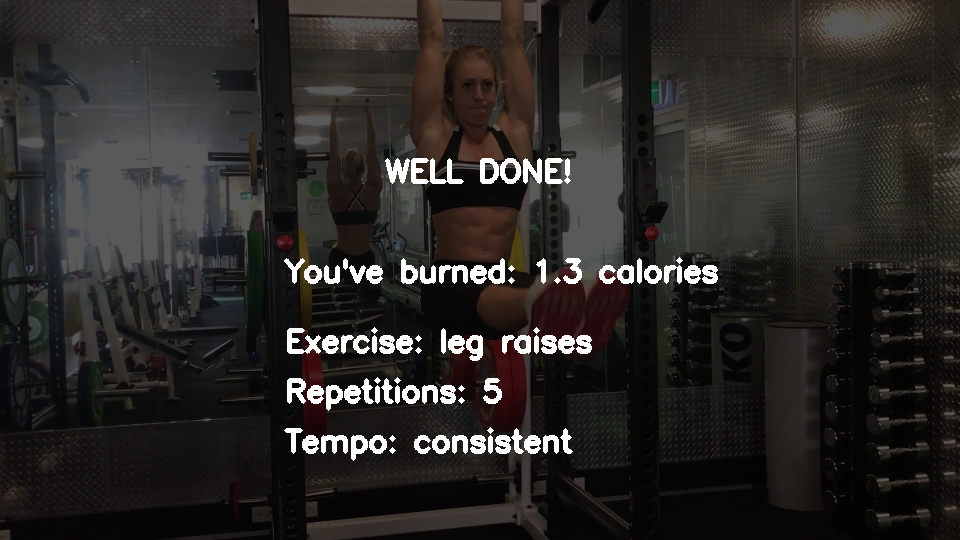

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np

def draw_workout_image(frames, calories, exercise, sets, consistent):

    background_frame = frames[400]
    background_frame = cv2.resize(background_frame, (background_frame.shape[1]//2, background_frame.shape[0]//2))


    dark_overlay = np.zeros_like(background_frame)
    alpha = 0.65
    dark_overlay[:] = (0, 0, 0)
    background_frame = cv2.addWeighted(background_frame, 1-alpha, dark_overlay, alpha, 0)

    text = "WELL DONE!"
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_thickness = 3
    text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    text_x = (background_frame.shape[1] - text_size[0]) // 2
    text_y = (background_frame.shape[0] + text_size[1]) // 2 - 100
    cv2.putText(background_frame, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness)


    calories_text = f"You've burned: {calories} calories"
    exercise_text = f"Exercise: {exercise}"
    sets_text = f"Repetitions: {sets}"
    if consistent:
      tempo_text = "Tempo: consistent"
    else:
      tempo_text = "Tempo: inconsistent"

    text_height = text_y + 100
    cv2.putText(background_frame, calories_text, (text_x-100, text_height), font, font_scale, (255, 255, 255), font_thickness)
    cv2.putText(background_frame, exercise_text, (text_x-100, text_height+70), font, font_scale, (255, 255, 255), font_thickness)
    cv2.putText(background_frame, sets_text, (text_x-100, text_height + 120), font, font_scale, (255, 255, 255), font_thickness)
    cv2.putText(background_frame, tempo_text, (text_x-100, text_height + 170), font, font_scale, (255, 255, 255), font_thickness)

    cv2_imshow(background_frame)


draw_workout_image(frames, calories=1.3, exercise='leg raises', sets=5, consistent=True )


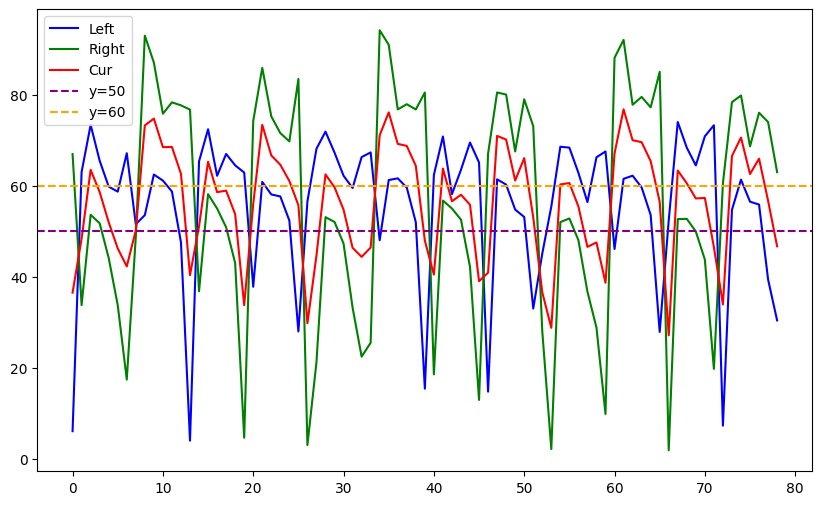

In [ ]:
import matplotlib.pyplot as plt


left = left_angles
right = right_angles
cur = current_angles
x = range(len(cur))


plt.figure(figsize=(10, 6))


plt.plot(x, left, label='Left', color='blue')
plt.plot(x, right, label='Right', color='green')
plt.plot(x, cur, label='Cur', color='red')
plt.axhline(y=50, label='y=50', color='purple', linestyle='--')
plt.axhline(y=60, label='y=60', color='orange', linestyle='--')



plt.legend()

plt.show()